# Text Classification Using Machine Learning
I classified BBC news articles using [Support Vector Machines](https://en.wikipedia.org/wiki/Support-vector_machine) and [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).
   
### Libaries that i use;
- numpy
- pandas
- seaborn
- matplotlib
- nltk
- re
- sklearn
- gensim


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

from gensim.models import Word2Vec  

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

[Natural Language Toolkit or nltk](https://en.wikipedia.org/wiki/Natural_Language_Toolkit) is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language.
- **punkt**: This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
- **stopwords**: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.
- **wordnet**: The WordNet is a part of Python's Natural Language Toolkit. It is a large word database of English Nouns, Adjectives, Adverbs and Verbs.

We are commenting these because we already have these datasets. If you dont have these you should run these for first time.

<AxesSubplot:xlabel='category', ylabel='count'>

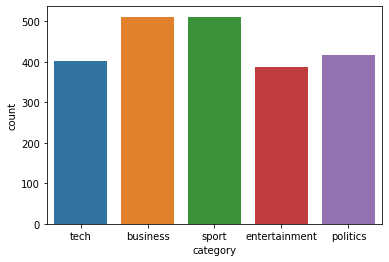

In [3]:
df=pd.read_csv("bbc-text.csv")
sns.countplot(x=df.category)

We load the dataset as pandas dataframe and visualize category distrubution using seaborn. Since the data balanced we can start  data preprocessing.

In [4]:
def Data_Preprocess(p_df):
    print('Data Preprocess started...')

    p_df['text_clean'] = p_df['text'].apply(nltk.word_tokenize)
    print('Tokenization completed.')

    stop_words=set(nltk.corpus.stopwords.words("english"))
    p_df['text_clean'] = p_df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
    print('Stop words removed.')

    regex = '[a-z]+'
    p_df['text_clean'] = p_df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
    print('Numbers, punctuation and special characters removed.')

    lem = nltk.stem.wordnet.WordNetLemmatizer()
    p_df['text_clean'] = p_df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
    print('Lemmatization completed.')
    print('Data cleaning completed.\n')
    
    print(p_df)
    return p_df

We are creating our CountVectorizer with our custom LemmaTokenizer and paramaters.
- Divide sentences into words
- Removed stop words, numbers, punctuation, special characters
- Lemmatization(Lemma means base form of a word.)

In [5]:
df=Data_Preprocess(df)

Data Preprocess started...
Tokenization completed.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization completed.
Data cleaning completed.

           category                                               text  \
0              tech  tv future in the hands of viewers with home th...   
1          business  worldcom boss  left books alone  former worldc...   
2             sport  tigers wary of farrell  gamble  leicester say ...   
3             sport  yeading face newcastle in fa cup premiership s...   
4     entertainment  ocean s twelve raids box office ocean s twelve...   
...             ...                                                ...   
2220       business  cars pull down us retail figures us retail sal...   
2221       politics  kilroy unveils immigration policy ex-chatshow ...   
2222  entertainment  rem announce new glasgow concert us band rem h...   
2223       politics  how political squabbles snowball it s become c...   
2224       

In [6]:
vec_model = Word2Vec(df['text_clean'])
w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.vectors))

We are training our gensim Word2Vec model. This gives us a dictionary that includes every word in our cleaned dataset.

In [7]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    

Vectorizer to use in classifier.

In [8]:
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

We are creating our classifier for our pipeline.

In [9]:
clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']}
}

We have created our models and their parameters.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'], df['category'], test_size=0.2, random_state=256)

Dataset divied  as features and labels. Also splitted as %80 train and %20 test. Since we used random_state we can get the same train-test data always.

In [11]:
accuracy={'Naive Bayes':0,'SVC':0}
f1={'Naive Bayes':0,'SVC':0}
log_loss={'Naive Bayes':0,'SVC':0}

We created these dictionaries for saving different classification metric scores.

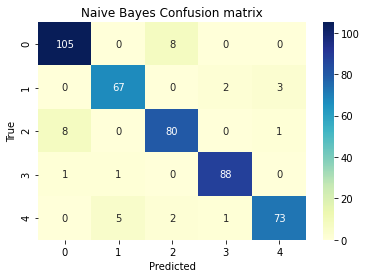

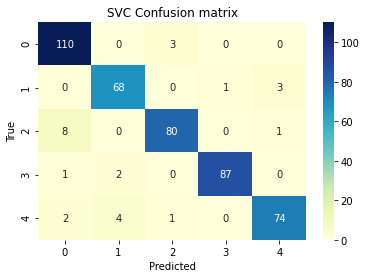

In [12]:
for key in clf_models.keys():    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    # Fitting the data
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
    labels = [0, 1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("bottom")
    plt.title(key+' Confusion matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    accuracy[key]=metrics.accuracy_score(y_test,y_pred)
    f1[key]=metrics.f1_score(y_test,y_pred,average='macro')
    log_loss[key]=metrics.accuracy_score(y_test,y_pred)

We trained our different classifiers, calculated their classification metric scores and created our heatmaps.

In [13]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Logarithmic Loss: ", log_loss)

Accuracy:  {'Naive Bayes': 0.9280898876404494, 'SVC': 0.9415730337078652}
F1 Score:  {'Naive Bayes': 0.9279058270631104, 'SVC': 0.9409757961532044}
Logarithmic Loss:  {'Naive Bayes': 0.9280898876404494, 'SVC': 0.9415730337078652}


Printing different classification metric scores.

In [14]:
def Plot(p_metric,p_values):    
    columns=p_values.keys()
    values=list(p_values.values())
    y_pos = np.arange(len(columns))

    plt.bar(y_pos, values, align='center', alpha=0.5,color=["red","blue"])
    plt.xticks(y_pos, columns)
    title=p_metric+' Score'
    plt.title(title)
    
    plt.figtext(0.5, 0.001, str(p_values), ha="center", fontsize=16)
    plt.show()

Function to plot different metric scores.

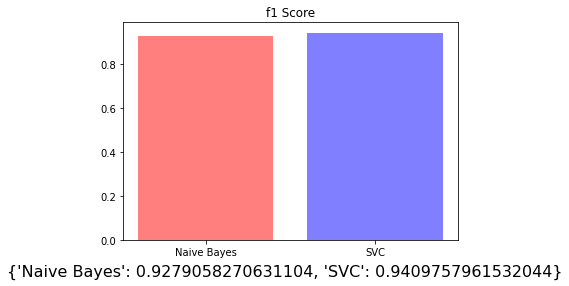

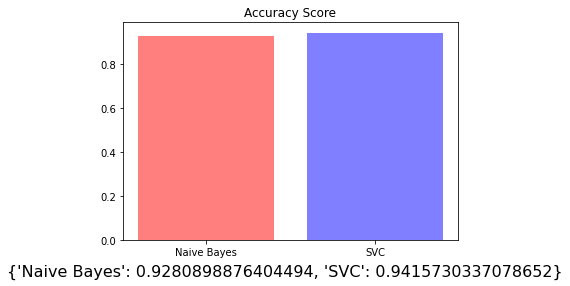

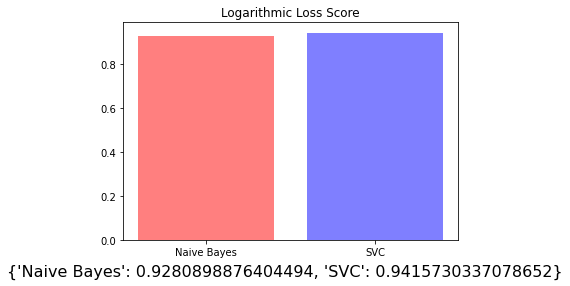

In [15]:
Plot("f1",f1)
Plot("Accuracy",accuracy)
Plot("Logarithmic Loss",log_loss)